# Credit Card Fraud Prediction Models

In this kernel we will evaluate different classification models and use different methods for handling imbalanced data.

 1. using class weights in our classification model
 2. using random undersampling during training

### Imports and helper functions

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
pd.set_option('display.max_columns', 500)
from tqdm import tqdm

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, RobustScaler

from sklearn.metrics import precision_recall_curve, average_precision_score, classification_report, confusion_matrix, f1_score, recall_score, precision_score

from sklearn.linear_model import LogisticRegression


In [2]:
def draw_pr_curve(y_true, scores):
    """
    draws precision-recall curves
    """
    prec, recall, thresholds = precision_recall_curve(y_true, scores)
    ap = average_precision_score(y_true, scores)
    plt.figure()
    lw = 2
    plt.plot(prec, recall, color='darkorange',
             lw=lw, label='Average Precision (ap = %0.2f)' % ap)
    plt.plot([0, 1], [1, 0], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall curve')
    plt.legend(loc="lower left")
    plt.show()

def draw_confusion_matrix(y_true, pred, normalize=True, print_report=True, title='Confusion Matrix', cmap=plt.cm.Blues):
    """
    draws confusion matrices and print a classification report
    """
    cm = confusion_matrix(y_true, pred)
    if normalize:
        cm = cm.astype("float") / cm.sum(axis=1)[:, None]
    
    sns.heatmap(cm, cmap='coolwarm_r', linewidths=0.5, annot=True)
    plt.title('Confusion Matrix')
    plt.ylabel('Real Classes')
    plt.xlabel('Predicted Classes')
    plt.show()
    
    if print_report:
        print('---Classification Report---')
        print(classification_report(y_true, pred)) 

### Reading in the data

In [3]:
df = pd.read_csv("Data/creditcard.csv")
#df.head()

## Logistic Regression

### Data preprocessing

For the "Time" feature we replace "elapsed time" with the "TimeTag" feature (EDA) and standardize our features.

In [4]:
X = df.drop(columns=["Class"])
y = df.Class.values

# use TimeTag (from EDA) instead of normal time
TimeTag = (X["Time"]/3600)%24
X["Time"] = np.array((TimeTag < 6) , dtype=np.int8) 

X = X.values

### Class weights

One straight forward way to handle class imbalances is the use of class weight.

To determine the right class weights we will use cross validation.

Since the data is heavily imbalanced we use average precision (ap) or the area under the Precision-Recall curve as classification metric as well as f1 score.

In [5]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=12)

weights = [1, 10, 20, 50, 100]

results_table = pd.DataFrame(index=range(len(weights)), columns=["class_weight", "mAP", "mF1-score", "mRecall", "mPrecision", "", "AP_Fold_1","AP_Fold_2","AP_Fold_3","AP_Fold_4","AP_Fold_5"])
results_table["class_weight"] = weights

for i, weight in enumerate(tqdm(weights)):
    
    APs = []
    F_scores = []
    Recall_scores = []
    Precision_scores = []
        
    for fold_nr, (train_index, test_index) in enumerate(tqdm(skf.split(X, y))):
        
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        model = LogisticRegression(class_weight={0:1,1:weight}, max_iter=250)
        
        # we use RobustScaler which uses median and interquartile range instead of mean and std  
        scaler = RobustScaler()
        scaler.fit(X_train)
        
        model.fit(scaler.transform(X_train), y_train)
        
        scores = model.predict_proba(scaler.transform(X_test))[:,1]
        ap = average_precision_score(y_test, scores)
        f_score = f1_score(y_test, scores > 0.5)
        recall = recall_score(y_test, scores > 0.5)
        precision = precision_score(y_test, scores > 0.5)
        APs.append(ap)
        F_scores.append(f_score)
        Recall_scores.append(recall)
        Precision_scores.append(precision)
        #print(ap)
        results_table.loc[i, ("AP_Fold_"+str(1+fold_nr))] = ap
    
    mAP = np.mean(APs)
    mF1 = np.mean(F_scores)
    mRecall = np.mean(Recall_scores)
    mPrecision = np.mean(Precision_scores)
    
    results_table.loc[i,"mAP"] = mAP
    results_table.loc[i,"mF1-score"] = mF1
    results_table.loc[i,"mRecall"] = mRecall
    results_table.loc[i,"mPrecision"] = mPrecision

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]
0it [00:00, ?it/s]
1it [00:05,  5.09s/it]
2it [00:11,  5.47s/it]
3it [00:18,  5.80s/it]
4it [00:25,  6.25s/it]
5it [00:31,  6.22s/it]
 20%|████████████████▊                                                                   | 1/5 [00:31<02:04, 31.11s/it]
0it [00:00, ?it/s]
1it [00:03,  3.75s/it]
2it [00:08,  3.93s/it]
3it [00:12,  4.07s/it]
4it [00:16,  4.03s/it]
5it [00:20,  4.05s/it]
 40%|█████████████████████████████████▌                                                  | 2/5 [00:51<01:23, 27.85s/it]
0it [00:00, ?it/s]
1it [00:04,  4.02s/it]
2it [00:08,  4.06s/it]
3it [00:12,  4.04s/it]
4it [00:15,  3.94s/it]
5it [00:19,  3.86s/it]
 60%|██████████████████████████████████████████████████▍                                 | 3/5 [01:10<00:50, 25.29s/it]
0it [00:00, ?it/s]
1it [00:03,  3.07s/it]
2it [00:06,  3.22s/it]
3it [00:10,  3.53s/it]
4it [00:14,  3.69s/it]
5it [00

In [6]:
results_table

,class_weight,mAP,mF1-score,mRecall,mPrecision,,AP_Fold_1,AP_Fold_2,AP_Fold_3,AP_Fold_4,AP_Fold_5
0,1,0.758725,0.719522,0.617934,0.864544,NaN,0.768639,0.80203,0.731441,0.711745,0.77977
1,10,0.760963,0.787416,0.814945,0.762263,NaN,0.782821,0.812177,0.732997,0.701199,0.775619
2,20,0.756894,0.741184,0.82717,0.67239,NaN,0.779568,0.808477,0.727578,0.696755,0.772091
3,50,0.75216,0.625587,0.851515,0.495276,NaN,0.77306,0.803118,0.72492,0.691362,0.76834
4,100,0.749437,0.424009,0.86576,0.28134,NaN,0.76811,0.796274,0.728854,0.685315,0.768631


The class weight 10 performs best in cross_validation (regarding average precision).

Let's take a closer look at the classifier at Fold 5 (where classification performance resembles the average the most)

In [7]:
train_idx, test_idx = list(skf.split(X,y))[4]
X_train, X_test = X[train_index], X[test_index]
y_train, y_test = y[train_index], y[test_index]

model = LogisticRegression(class_weight={0:1,1:10}, max_iter=250)

scaler = RobustScaler()
scaler.fit(X_train)

model.fit(scaler.transform(X_train), y_train)

scores = model.predict_proba(scaler.transform(X_test))[:,1]

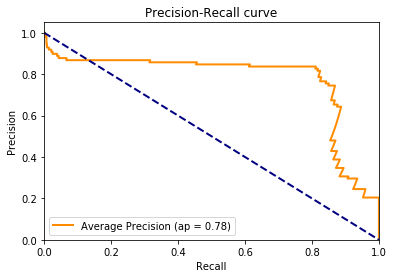

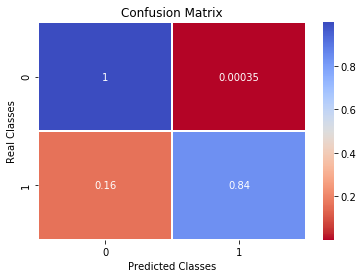

---Classification Report---
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       0.80      0.84      0.82        98

    accuracy                           1.00     56961
   macro avg       0.90      0.92      0.91     56961
weighted avg       1.00      1.00      1.00     56961



In [8]:
draw_pr_curve(y_test, scores)
draw_confusion_matrix(y_test, scores > 0.5)

We can see that just tuning the class weights for logistic regression can give a good classifier.

Note that in a real world fraud detector one would - depending on the cost of FPs and FNs - tune a classifier a bit more. <br>
For example with the cost for False Negatives is very low, one would prefer a model with higher recall.

### Undersampling

Another way to handle class imbalances is to randomly undersample the non-fraudulent samples in training.

In [9]:
def undersample(X, y, sample_factor=1, shuffled=True, random_state=None):
    """
    Undersamples the non-fraudulent samples
    
    sample_factor gives the amount of non-fraud samples for every fraud sample
    """
    X_fraud = X[y==1]
    X_non_fraud = X[y==0]
    
    fraud_samples = len(X_fraud)
    non_fraud_total = len(X_non_fraud)
        
    np.random.RandomState(seed=random_state)
    non_fraud_indices = np.random.choice(non_fraud_total, int(fraud_samples*sample_factor), replace=False)
    
    X_no_undersampled = X_non_fraud[non_fraud_indices]
    
    X_undersampled = np.concatenate((X_fraud, X_no_undersampled))
    y_undersampled = np.concatenate((np.ones(fraud_samples), np.zeros(len(X_no_undersampled))))
    
    if shuffled:
        X_undersampled, y_undersampled = shuffle(X_undersampled, y_undersampled, random_state=random_state)
    
    return X_undersampled , y_undersampled  


In [14]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=12)

sample_factors = [1, 1.5, 2, 4, 6, 9, 19, 39, 59, 79]

results_table = pd.DataFrame(index=range(len(sample_factors)), columns=["sample_factors", "mAP", "mF1-score", "mRecall", "mPrecision", "AP_Fold_1","AP_Fold_2","AP_Fold_3","AP_Fold_4","AP_Fold_5"])
results_table["sample_factors"] = sample_factors

for i, factor in enumerate(tqdm(sample_factors)):
    
    APs = []
    F_scores = []
    Recall_scores = []
    Precision_scores = []
        
    for fold_nr, (train_index, test_index) in enumerate(skf.split(X, y)):
        
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        model = LogisticRegression(max_iter=250)
        
        # we use RobustScaler which uses median and interquartile range instead of mean and std  
        scaler = RobustScaler()
        scaler.fit(X_train)
        X_undersampled, y_undersampled = undersample(scaler.transform(X_train), y_train, sample_factor=factor, random_state=12)
        
        model.fit(X_undersampled, y_undersampled)
        
        scores = model.predict_proba(scaler.transform(X_test))[:,1]
        ap = average_precision_score(y_test, scores)
        f_score = f1_score(y_test, scores > 0.5)
        recall = recall_score(y_test, scores > 0.5)
        precision = precision_score(y_test, scores > 0.5)
        APs.append(ap)
        F_scores.append(f_score)
        Recall_scores.append(recall)
        Precision_scores.append(precision)
        #print(ap)
        results_table.loc[i, ("AP_Fold_"+str(1+fold_nr))] = ap
    
    mAP = np.mean(APs)
    mF1 = np.mean(F_scores)
    mRecall = np.mean(Recall_scores)
    mPrecision = np.mean(Precision_scores)
    
    results_table.loc[i,"mAP"] = mAP
    results_table.loc[i,"mF1-score"] = mF1
    results_table.loc[i,"mRecall"] = mRecall
    results_table.loc[i,"mPrecision"] = mPrecision

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:43<00:00,  4.34s/it]


In [15]:
results_table

,sample_factors,mAP,mF1-score,mRecall,mPrecision,AP_Fold_1,AP_Fold_2,AP_Fold_3,AP_Fold_4,AP_Fold_5
0,1.0,0.631922,0.0849893,0.910534,0.0446562,0.594095,0.624496,0.656704,0.580654,0.703661
1,1.5,0.638126,0.100113,0.910534,0.0529919,0.473043,0.738645,0.690729,0.552941,0.735272
2,2.0,0.630678,0.152529,0.892208,0.0834524,0.530585,0.738668,0.638241,0.521315,0.724583
3,4.0,0.706355,0.256208,0.871841,0.150405,0.752089,0.77874,0.646365,0.612999,0.74158
4,6.0,0.715018,0.355319,0.86578,0.225901,0.745265,0.795115,0.703544,0.667069,0.6641
5,9.0,0.715873,0.460802,0.857638,0.31553,0.752663,0.76031,0.718145,0.632115,0.716133
6,19.0,0.73367,0.658407,0.841394,0.543917,0.736913,0.783623,0.73145,0.67564,0.740724
7,39.0,0.742437,0.730798,0.814945,0.662903,0.767245,0.794237,0.692587,0.689074,0.769044
8,59.0,0.748269,0.767645,0.812905,0.727823,0.775204,0.808034,0.705086,0.678276,0.774742
9,79.0,0.754793,0.779628,0.792538,0.768107,0.758322,0.811642,0.729565,0.701821,0.772614


- We can see that undersampling is a valid strategy for dealing with highly imbalanced data.
- As the amount of non-fraudulent samples increases recall drops and average precision increases
- The sample factor 79 performs best (regarding AP), however worse than the classifier trained using class weights in both AP and recall
- A big advantage of undersampling compared to using class weights is that training is much faster, due to the much smaller training set

Let's again take a closer look at the classifier at fold 5

In [20]:
train_idx, test_idx = list(skf.split(X,y))[4]
X_train, X_test = X[train_index], X[test_index]
y_train, y_test = y[train_index], y[test_index]

model = LogisticRegression(max_iter=250)

# we use RobustScaler which uses median and interquartile range instead of mean and std  
scaler = RobustScaler()
scaler.fit(X_train)
X_undersampled, y_undersampled = undersample(scaler.transform(X_train), y_train, sample_factor=79, random_state=12)

model.fit(X_undersampled, y_undersampled)

scores = model.predict_proba(scaler.transform(X_test))[:,1]

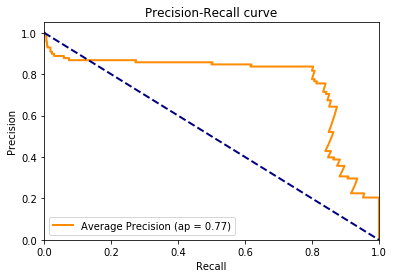

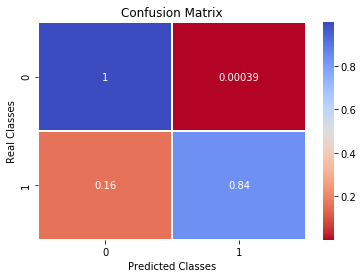

---Classification Report---
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       0.79      0.84      0.81        98

    accuracy                           1.00     56961
   macro avg       0.89      0.92      0.91     56961
weighted avg       1.00      1.00      1.00     56961



In [21]:
draw_pr_curve(y_test, scores)
draw_confusion_matrix(y_test, scores > 0.5)

## Decision Trees

comming soon...